In [1]:
from pynq import Overlay, allocate
from pynq.lib.video import VideoMode
from pynq import MMIO
import cv2
from matplotlib import pyplot as plt
import time
import numpy as np
import math

overlay = Overlay('ebaz_hdmi_test.bit')
help(overlay)

Matplotlib is building the font cache; this may take a moment.


Help on Overlay in module pynq.overlay:

<pynq.overlay.Overlay object>
    Default documentation for overlay ebaz_hdmi_test.bit. The following
    attributes are available on this overlay:
    
    IP Blocks
    ----------
    axi_gpio_0           : pynq.lib.axigpio.AxiGPIO
    axi_intc             : pynq.overlay.DefaultIP
    axi_uartlite_0       : pynq.overlay.DefaultIP
    axi_vdma             : pynq.lib.video.dma.AxiVDMA
    processing_system7_0 : pynq.overlay.DefaultIP
    
    Hierarchies
    -----------
    None
    
    Interrupts
    ----------
    None
    
    GPIO Outputs
    ------------
    None
    
    Memories
    ------------
    PSDDR                : Memory



In [2]:
r_width = 320
r_height = 240

# colors in hsv space
low = np.array((50, 50, 50), np.uint8)
high = np.array((100, 255, 255), np.uint8)

l_speed = 5
r_speed = 5

l_k = 5
r_k = 5

In [3]:
address = 0x42C00000

# HARDWARE CONSTANTS
RX_FIFO = 0x00
TX_FIFO = 0x04

# Status Reg
STAT_REG = 0x08
RX_VALID = 0
RX_FULL = 1
TX_EMPTY = 2
TX_FULL = 3
IS_INTR = 4
OVERRUN_ERR = 5
FRAME_ERR = 6
PARITY_ERR = 7

# Ctrl Reg
CTRL_REG = 0x0C
RST_TX = 0
RST_RX = 1
INTR_EN = 4

# Offset Settings
XGPIO_DATA_OFFSET = 0x0
XGPIO_TRI_OFFSET = 0x4

class UartAXI:
    def __init__(self, address):
        # Setup axi core
        self.uart = MMIO(address, 0x10000, debug=False)
        self.address = address

    def setupCtrlReg(self):
        # Reset FIFOs, disable interrupts
        self.uart.write(CTRL_REG, 1 << RST_TX | 1 << RST_RX)
        time.sleep(1)
        self.uart.write(CTRL_REG, 0)
        time.sleep(1)

    def read(self, count, timeout=10):
        # status = currentStatus(uart) bad idea
        buf = ""
        stop_time = time.time() + timeout
        for i in range(count):
            # Wait till RX fifo has valid data, stop waiting if timeoutpasses
            while (not (self.uart.read(STAT_REG) & 1 << RX_VALID)) and (time() < stop_time):
                pass
            if time.time() >= stop_time:
                break
            buf += chr(self.uart.read(RX_FIFO))
        return buf

    def write(self, buf, timeout=10):
        # Write bytes via UART
        stop_time = time.time() + timeout
        wr_count = 0
        for i in buf:
            # Wait while TX FIFO is Full, stop waiting if timeout passes
            while (self.uart.read(STAT_REG) & 1 << TX_FULL) and (time() < stop_time):
                pass
            # Check timeout
            if time.time() > stop_time:
                break
            self.uart.write(TX_FIFO, ord(i))
            wr_count += 1
        return wr_count
    
uart = UartAXI(address)
# Setup AXI UART register
uart.setupCtrlReg()

In [4]:
frameMode = VideoMode(1280, 720, 24, 50)
vdma = overlay.axi_vdma
vdma.readchannel.mode = frameMode
vdma.readchannel.start()

time.sleep(0.1)

/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:709: UserWarning: Interrupt mm2s_introut not created: Could not find UIO device for interrupt pin for IRQ number 61
  warnings.warn("Interrupt {} not created: {}".format(interrupt, str(e)))
/usr/local/share/pynq-venv/lib/python3.10/site-packages/pynq/overlay.py:709: UserWarning: Interrupt s2mm_introut not created: Could not find UIO device for interrupt pin for IRQ number 61
  warnings.warn("Interrupt {} not created: {}".format(interrupt, str(e)))


In [5]:
while(True):
    try:
        image = vdma.readchannel.readframe()
    except:
        continue
        
    image = cv2.resize(image,(r_width,r_height))
        
    # Converting the image to HSV format
    img_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Get masks by colors in a certain range
    mask = cv2.inRange(img_hsv, low, high)

    # compute the center of the contour
    M = cv2.moments(mask, 1)

    moments = cv2.moments(mask, 1)
    dM01 = moments['m01']
    dM10 = moments['m10']
    dArea = moments['m00']

    if dArea >= 100:
        x = int(dM10 / dArea)
        y = int(dM01 / dArea)
        cv2.circle(image, (x, y), 10, (0,0,255), -1)

        delta = ((dM10 / dArea) - r_width / 2) / (r_width / 2) 

        cv2.putText(image, str(delta), (int(r_width / 2) , int(r_height / 2)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

        left = int(l_speed + l_k * delta)
        right = int(r_speed - r_k * delta)

        uart.write('DD')
        #time.sleep(0.005)

        send_str = 'L{}'.format(left)
        uart.write(send_str)
        
        #time.sleep(0.005)

        send_str = 'R{}'.format(right)
        uart.write(send_str)

        #plt.imshow(image)
        cv2.imwrite("hello.jpg", image) 

KeyboardInterrupt: 

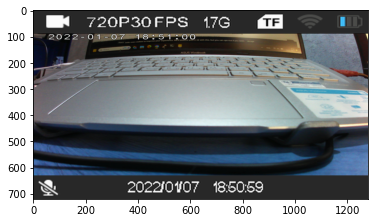

In [6]:
vdma.readchannel.stop()
uart.write('DD')